# Background
[**Titanic: Machine Learning from Disaster**](https://www.kaggle.com/c/titanic) is a famous Kaggle competition in which participants are asked to build machine learning models to predict if a passenger will survive or not. It is a great resource for practicing data analysis skills for self-learning students like myself. In this notebook, I present how I handle the dataset and eventually build a model with a testing dataset prediction accuracy of 78.7%.

## Overview
The main steps that I took to complete the competition are as follow:
#### 1. Understand the shape of the data through visualization (histogram, bar plots)
#### 2. Data preprocessing and feature engineering
#### 3. Model building and fine-tuning

## 1. Understand the shape of the data

### Data Overview

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Read the training and testing data
train = pd.read_csv("train.csv")

In [3]:
# View the data
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


According to the above summary, there are in total 12 columns in the training dataset: 7 numerical columns and 5 categorical columns. Missing values exist in *Age*, *Cabin*, and *Embarked* columns, especially in *Cabin* columns, where only 204 out of 891 values are not null. *PassengerId* and *Ticket* columns should be specific to each passenger and therefore may not have impact on the survival result. Even though the values in the *name* column is also specific to each passenger, some of them share common titles (Mr. Mrs. etc.), so this might be valuable to extract later. 

### Data Visualization

Let's first see the numerical columns:

In [5]:
# Numerical columns
num_cols = ["PassengerId", "Survived", "Pclass", "Age", "SibSp", "Parch", "Fare"]

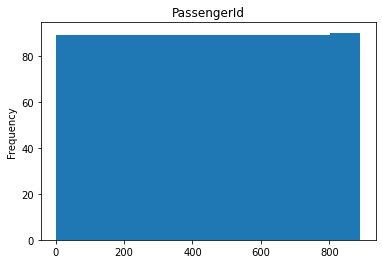

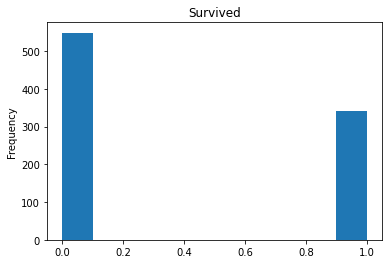

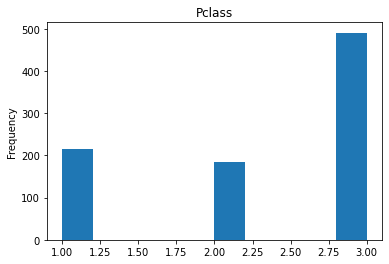

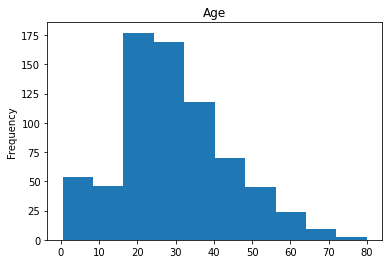

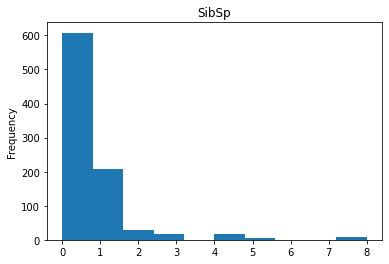

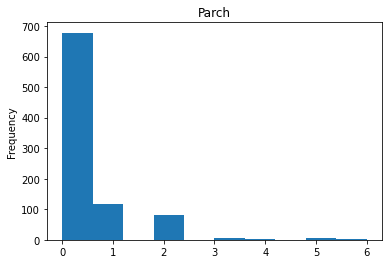

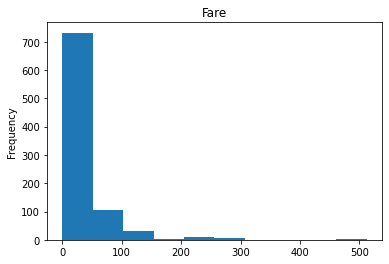

In [6]:
# Look the numerical data through frequency
for col in num_cols:
    fig = plt.figure()
    train[col].plot(kind='hist', title='{}'.format(col))
plt.show()

From the above graphs, as expected, *PassengerId* is specific to each passenger; There were more passengers that did not survive; The number of passengers in Class 1 and Class 2 were similar and lower than the number of passengers in Class 3; *Age* has values from 0 to 80 years old and has a distribution similar to a normal distribution; *SibSp* and *Parch* both have their most values equal to 0 and 1; *Fare* has its most values under 150. Let's see how the rest of the columns correlate with *Survived* column.

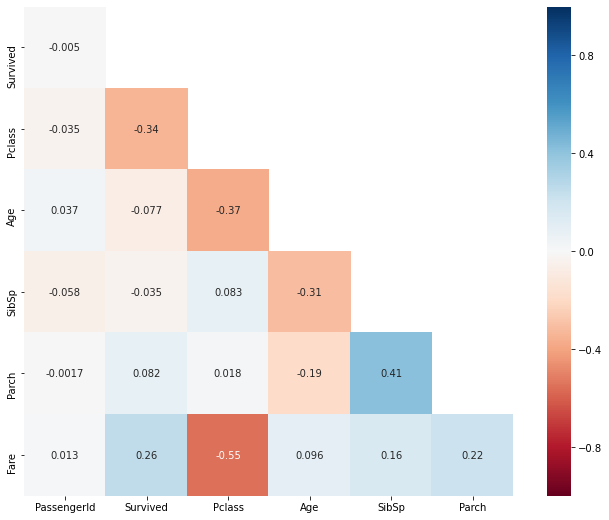

In [7]:
# Correlations between numerical columns and Survived column
num_train = train[num_cols]
corr = num_train.corr()
corr = corr.iloc[1:, :-1]
mask = np.triu(np.ones_like(corr), k=1)
plt.figure(figsize=(12,9))
ax=sns.heatmap(corr, vmin=-1, vmax=1, cmap='RdBu', mask=mask, annot=True, square=True)

From the above correlation graph we notice that:
1.  As expected, *PassengerId* does not have any correlation with the survival status.
2. *Pclass* has a strong negative correlation with the survival status - the lower the Pclass value, the higher the chance to survive. Lower *Pclass* indicates more luxurious class. Thus in this case, richer people seem to have a higher chance to survive. This hypothesis is also evidenced in the significant positive correlations between *Fare* and *Survived*.
3. *Age* has a slightly negative correlation with surivial status. It makes sense as younger people usually have priority to be rescued. I expected *Age* to have a stronger negative correlation, but it does not. The possible reason can be the strong negative correlation between *Age* and *Pclass* - the younger people are mainly in higher classes, which have lower chances to survive.
4. Interestingly, SibSp (# of siblings / spouses aboard the Titanic) and Parch (# of parents / children aboard the Titanic) both indicate the number of family members aboard but have opposite impact on the surivival rate.

Now let's take a look at the categorical columns:

In [8]:
# Categorical columns
cal_cols = ["Name", "Sex", "Ticket", "Cabin", "Embarked"]

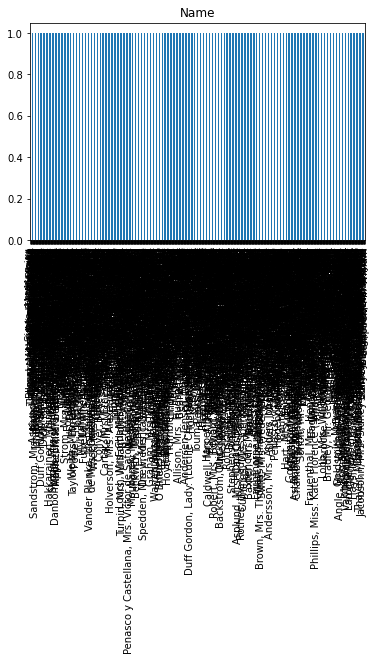

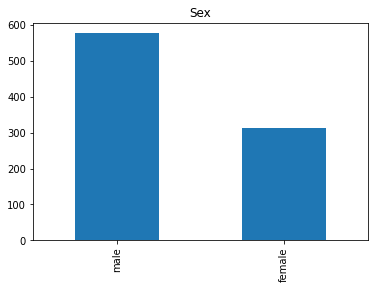

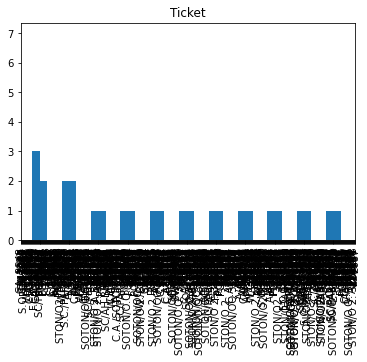

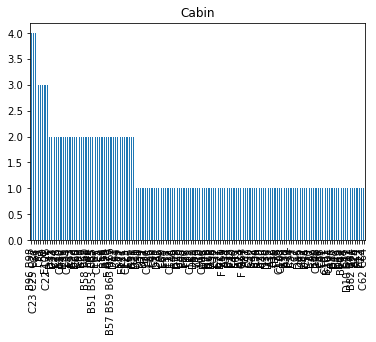

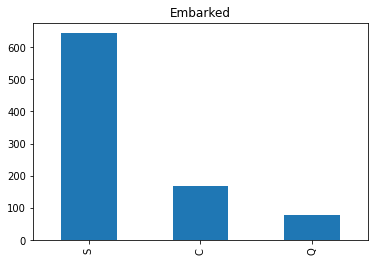

In [9]:
# Look the categorical data through value_counts
for col in cal_cols:
    fig = plt.figure()
    train[col].value_counts().plot(kind='bar', title='{}'.format(col))
    
plt.show()

As expected, *Name*, *Ticket*, and *Cabin* columns have large numbers of different values. They require further processing before use them in models. *Sex* and *Embarked* can be directly used. Let's see how they correlate with the survival status:

In [10]:
print(pd.pivot_table(train, values="PassengerId", index="Survived", columns="Sex", aggfunc="count"))
print("\n")
print(pd.pivot_table(train, values="PassengerId", index="Survived", columns="Embarked", aggfunc="count"))

Sex       female  male
Survived              
0             81   468
1            233   109


Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


As can be seen from the above pivot tables, both *Sex* and *Embarked* have great impacts on the survival status. 
1. Much more females survived compared to males
2. Passengers embarked from port Cherbourg have highest surivial rate, then from port Queenstown, then from port Southampton.

## Data Preprocessing and Feature Engineering

### Missing Values

From the above overview, three columns contain missing values: *Age*, *Cabin*, and *Embarked*. *Cabin* column has the most missing values, so let's take a look at this column first to see if we can replace the missing value with some known values.

In [11]:
train["Cabin"].value_counts()

B96 B98        4
C23 C25 C27    4
G6             4
F33            3
F2             3
              ..
A26            1
A14            1
E12            1
A23            1
C62 C64        1
Name: Cabin, Length: 147, dtype: int64

Interestingly, all cabins have a combination of a alphabetic letter followed by a number. Thus, I can reorganize the column by removing the number and retaining the letter. 

In [12]:
train["CabinLetters"] = train["Cabin"].str[0]
train["CabinLetters"].value_counts()

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: CabinLetters, dtype: int64

Now the unique number of cabins is decreased down to 8. In common large transportation units, cabins are subsets of classes. Let's see if it is true in this case:

In [13]:
pd.pivot_table(train, values="PassengerId", index="Pclass", columns="CabinLetters", aggfunc="count")

CabinLetters,A,B,C,D,E,F,G,T
Pclass,,,,,,,,
1,15.0,47.0,59.0,29.0,25.0,NaN,NaN,1.0
2,NaN,NaN,NaN,4.0,4.0,8.0,NaN,NaN
3,NaN,NaN,NaN,NaN,3.0,5.0,4.0,NaN


We can see that all passengers in cabins A, B, C, and T are from Pclass 1, and all passengers in cabin G are from Pclass 2. However, passengers in cabins D, E and F are from different Pclasses. Therefore, it is not possible to assign the missing values of cabins based on the Pclass values. Thus, I consider drop the entire column.

In [14]:
train = train.drop(columns=["Cabin", "CabinLetters"])

The second column with missing values is the *Age* column. I could simply fill the missing values by the average of the *Age* column. **However, since there are different titles in the *Name* column (Mr. Mrs. etc.), I think I can do better by replacing the missing values with the average of the ages under certain title.** For example, if a passenger has a title Miss has her age missing, I can fill it up with the average age of all passengers with a title Miss. So, let's deal with the *Age* column later.

The third column with missing values is the *Embarked* column. Since there are only two missing values, I will simply fill the missing values by the most frequent value.

In [15]:
train["Embarked"] = train["Embarked"].fillna(train["Embarked"].mode().iloc[0])

### Feature Engineering

As mentioned above, the titles under *Name* column may be a valuable feature. So I use some regular expression to extract the titles:

In [16]:
train["NameTitle"] = train["Name"].str.extract(r"\w+\,\s(\w*\s?\w*)")
train["NameTitle"].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
Jonkheer          1
Lady              1
Don               1
Mme               1
Capt              1
Sir               1
Ms                1
the Countess      1
Name: NameTitle, dtype: int64

There are many titles that only few passengers have them. Since the data sizes for them are too small, it is better to merge them with more general titles:

In [17]:
# Reset the titles to more general ones
def reset_title(row):
    title = row["NameTitle"]
    if title in ["Rev", "Major", "Col", "Jonkheer", "Don", "Sir", "Capt"]:
        return "Mr"
    elif title == "Dr":
        if row["Sex"] == "male":
            return "Mr"
        else:
            return "Mrs"
    elif title in ["Mlle", "Ms"]:
        return "Miss"
    elif title in ["Mme", "Lady", "the Countess"]:
        return "Mrs"
    else:
        return title
train["NameTitle"] = train.apply(reset_title, axis=1)
train["NameTitle"].value_counts()

Mr        537
Miss      185
Mrs       129
Master     40
Name: NameTitle, dtype: int64

Now I can use these titles to calculate the average ages and fill up the missing values in the *Age* column.

In [18]:
# Fill the missing values in ages by the average age of the corresponding title of the person
mean_ages = {}
for title in train["NameTitle"].unique():
    mean_ages[title] = train.loc[train["NameTitle"]==title, "Age"].mean()
def fill_age(row):
    age = row["Age"]
    title = row["NameTitle"]
    if np.isnan(age):
        return mean_ages[title]
    else:
        return age
train["Age"] = train.apply(fill_age, axis=1)

*SibSp* and *Parch* columns both represent the number of family members. Thus, I combine these two columns together as one:

In [19]:
train["Family"] = train["SibSp"] + train["Parch"]

# Model Training And Fine-Tuning

Here I used five different machine learning models, and after fine-tuing, their cross-validation scores are as follow:


In [20]:
train_clean = train[["Survived", "Pclass", "Sex", "Age", "Fare", "Embarked", "Family", "NameTitle"]]

In [21]:
# Convert categorical columns to one-hot form
sex = pd.get_dummies(train_clean["Sex"], prefix="Sex")
embarked = pd.get_dummies(train_clean["Embarked"], prefix="Embarked")
nametitle = pd.get_dummies(train_clean["NameTitle"], prefix="Name")
pclass = pd.get_dummies(train_clean["Pclass"], prefix="Pclass")

In [22]:
# Merge the one-hot form columns and drop the original ones
train_clean = pd.concat([train_clean, sex, embarked, nametitle, pclass], axis=1)
train_clean = train_clean.drop(columns=["Sex", "Embarked", "NameTitle", "Pclass"])

In [23]:
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
Survived       891 non-null int64
Age            891 non-null float64
Fare           891 non-null float64
Family         891 non-null int64
Sex_female     891 non-null uint8
Sex_male       891 non-null uint8
Embarked_C     891 non-null uint8
Embarked_Q     891 non-null uint8
Embarked_S     891 non-null uint8
Name_Master    891 non-null uint8
Name_Miss      891 non-null uint8
Name_Mr        891 non-null uint8
Name_Mrs       891 non-null uint8
Pclass_1       891 non-null uint8
Pclass_2       891 non-null uint8
Pclass_3       891 non-null uint8
dtypes: float64(2), int64(2), uint8(12)
memory usage: 38.4 KB


In [24]:
# Set the target and features
X = train_clean.iloc[:, 1:]
y = train_clean.iloc[:, 0]

### Basic Model Setup

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier

In [26]:
# Logistic Regression
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(solver='lbfgs'))
cv = cross_val_score(pipe_lr, X, y, cv=5)
print(cv)
print(cv.mean())

[0.83240223 0.82681564 0.80337079 0.80898876 0.87570621]
0.8294567284692071


In [27]:
# SVC
pipe_svc = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='auto', probability=True))
cv = cross_val_score(pipe_svc, X, y, cv=5)
print(cv)
print(cv.mean())

[0.82681564 0.83240223 0.84831461 0.78089888 0.8700565 ]
0.8316975714832362


In [28]:
# K-Neighbors
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=10))
cv = cross_val_score(pipe_svc, X, y, cv=5)
print(cv)
print(cv.mean())

[0.82681564 0.83240223 0.84831461 0.78089888 0.8700565 ]
0.8316975714832362


In [29]:
# Ensemble Learning
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('lr', pipe_lr), ('svc', pipe_svc), ('knn', pipe_knn)], voting='soft')
cv = cross_val_score(voting_clf, X, y, cv=5)
print(cv)
print(cv.mean())

[0.82681564 0.83798883 0.83707865 0.79213483 0.88700565]
0.836204720427465


In [30]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='gini', n_estimators=150, random_state=1)
cv = cross_val_score(forest, X, y, cv=5)
print(cv)
print(cv.mean())

[0.78212291 0.79888268 0.83707865 0.76966292 0.83615819]
0.8047810703432564


### Fine-tuning Using GridSearch

In [31]:
# Logistic Regression
from sklearn.model_selection import GridSearchCV
param_grid = {'logisticregression__solver': ['liblinear', 'lbfgs'], 'logisticregression__C': np.logspace(-10,10,50)}
gs = GridSearchCV(estimator=pipe_lr, param_grid=param_grid, scoring='accuracy', cv=5, refit=True, n_jobs=-1)
gs.fit(X, y)
print(gs.best_score_)
print(gs.best_params_)
pipe_lr_best = gs.best_estimator_

0.8316498316498316
{'logisticregression__C': 0.09540954763499963, 'logisticregression__solver': 'liblinear'}


In [32]:
# SVC
param_grid = {'svc__kernel': ['sigmoid', 'rbf'], 'svc__C': np.logspace(-5,5,20)}
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid, scoring='accuracy', cv=5, refit=True, n_jobs=-1)
gs.fit(X, y)
print(gs.best_score_)
print(gs.best_params_)
pipe_svc_best = gs.best_estimator_

0.8338945005611672
{'svc__C': 1.8329807108324339, 'svc__kernel': 'rbf'}


C:\Users\kuanw\anaconda\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [33]:
# K-Neighbors
param_grid = {'kneighborsclassifier__n_neighbors': [6, 8, 10, 12], 
              'kneighborsclassifier__weights': ['uniform', 'distance'], 
              'kneighborsclassifier__algorithm': ['ball_tree', 'kd_tree', 'brute'], 
              'kneighborsclassifier__p': [1, 2]}
gs = GridSearchCV(estimator=pipe_knn, param_grid=param_grid, scoring='accuracy', cv=5, refit=True, n_jobs=-1)
gs.fit(X, y)
print(gs.best_score_)
print(gs.best_params_)
pipe_knn_best = gs.best_estimator_

0.8226711560044894
{'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 12, 'kneighborsclassifier__p': 2, 'kneighborsclassifier__weights': 'uniform'}


In [34]:
# Use the best models for voting classifier
voting_clf_best = VotingClassifier(estimators=[('lr', pipe_lr_best), ('svc', pipe_svc_best), ('knn', pipe_knn_best)], voting='hard')
cv = cross_val_score(voting_clf, X, y, cv=5)
print(cv)
print(cv.mean())

[0.82681564 0.83798883 0.83707865 0.79213483 0.88700565]
0.836204720427465


In [35]:
# Random Forests Randomized Search
from sklearn.model_selection import RandomizedSearchCV
param_grid = {'n_estimators':[100, 200, 300, 400, 500], 
              'max_features': ['auto', 'log2', 'sqrt'],
              'bootstrap': [True, False],
             'max_depth': [10, 20, 30, 50, 100, None],
             'min_samples_split':[2, 3, 4, 5],
             'min_samples_leaf': [1, 2, 3, 4]}
rs = RandomizedSearchCV(forest, param_grid, scoring='accuracy', cv=5, refit=True, n_jobs=-1)
rs.fit(X, y)
print(rs.best_score_)
print(rs.best_params_)

0.8338945005611672
{'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': None, 'bootstrap': True}


In [36]:
# Random Forests Grid Search
forest = RandomForestClassifier(max_features='auto', max_depth=None, bootstrap=True)
param_grid = {'n_estimators':[400, 430, 460],
             'min_samples_split':[3, 4, 5, 6],
             'min_samples_leaf': [3, 4, 5, 6]}
gs = GridSearchCV(estimator=forest, param_grid=param_grid, scoring='accuracy', cv=5, refit=True, n_jobs=-1)
gs.fit(X, y)
print(gs.best_score_)
print(gs.best_params_)
forest_best = gs.best_estimator_

0.8372615039281706
{'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 430}


# Submit Results to Kaggle

In [37]:
# import test dataset
test = pd.read_csv('test.csv')

### Preprocessing test dataset

In [38]:
# Preprocessing test dataset
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [39]:
# Name Title
test["NameTitle"] = test["Name"].str.extract(r"\w+\,\s(\w*\s?\w*)")
test["NameTitle"] = test.apply(reset_title, axis=1)
test["NameTitle"].value_counts()

Mr        245
Miss       79
Mrs        72
Master     21
Dona        1
Name: NameTitle, dtype: int64

In [40]:
test["NameTitle"] = test["NameTitle"].str.replace("Dona", "Mrs")

In [41]:
# Ages
mean_ages = {}
for title in test["NameTitle"].unique():
    mean_ages[title] = test.loc[test["NameTitle"]==title, "Age"].mean()
test["Age"] = test.apply(fill_age, axis=1)

# Family 
test["Family"] = test["SibSp"] + test["Parch"]

# Replace the missing value in Fare by the average
test["Fare"] = test["Fare"].fillna(test["Fare"].mean())

In [42]:
test_clean = test[["Pclass", "Sex", "Age", "Fare", "Embarked", "Family", "NameTitle"]]
# Convert categorical columns to one-hot form
sex = pd.get_dummies(test_clean["Sex"], prefix="Sex")
embarked = pd.get_dummies(test_clean["Embarked"], prefix="Embarked")
nametitle = pd.get_dummies(test_clean["NameTitle"], prefix="Name")
pclass = pd.get_dummies(test_clean["Pclass"], prefix="Pclass")
# Merge the one-hot form columns and drop the original ones
test_clean = pd.concat([test_clean, sex, embarked, nametitle, pclass], axis=1)
test_clean = test_clean.drop(columns=["Sex", "Embarked", "NameTitle", "Pclass"])

### Submission

In [43]:
fit = voting_clf_best.fit(X, y)
y_pred = voting_clf_best.predict(test_clean)

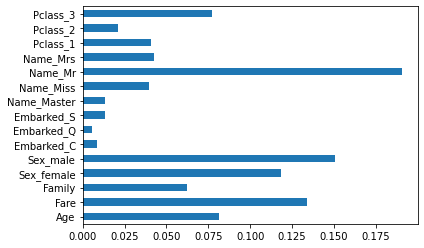

In [44]:
forest_best.fit(X,y)
feature_importances = pd.Series(forest_best.feature_importances_, index=X.columns)
feature_importances.plot(kind="barh")

In [45]:
submission = pd.concat([test["PassengerId"], pd.DataFrame(y_pred, columns=["Survived"])], axis=1)
submission.to_csv("submission_voting_v2.csv", index=False)

### Best Model

Turns out the model that gives me the highest accuracy score is *pipe_knn_best* (78.7%). This is suprising to me as I thought the ensemble classifiers such as *voting_clf_best* or *forest_best* would give me the best result. The image below shows my submissions:

![image](capture.PNG)